# Predicting Corona Virus

> **Authors**
- [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)
- [Peifan Wu *UBC*](https://economics.ubc.ca/faculty-and-staff/peifan-wu/)


**Prerequisites**

- [Regression](regression.ipynb)  
- [Visualizing Corona Virus](covid-trends.ipynb)  


**Outcomes**

- Apply prediction methods to data on Corona Virus  

## Outline

- [Predicting Corona Virus](#Predicting-Corona-Virus)  
  - [Introduction](#Introduction)  
  - [Data](#Data)  
  - [Predicting growth rates](#Predicting-growth-rates)  
  - [Exercises](#Exercises)  

In [43]:
# Uncomment following line to install on colab
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

     |████████████████████████████████| 148.9 MB 79 kB/s s eta 0:00:01    |███                             | 14.2 MB 10.0 MB/s eta 0:00:14     |██████▉                         | 32.0 MB 25.1 MB/s eta 0:00:05     |███████▎                        | 33.8 MB 25.1 MB/s eta 0:00:05     |███████▌                        | 34.7 MB 25.1 MB/s eta 0:00:05     |████████▌                       | 39.6 MB 25.1 MB/s eta 0:00:05     |██████████▊                     | 49.8 MB 32.0 MB/s eta 0:00:04     |███████████▌                    | 53.3 MB 32.0 MB/s eta 0:00:03     |████████████                    | 55.7 MB 32.0 MB/s eta 0:00:03     |████████████▋                   | 58.9 MB 32.0 MB/s eta 0:00:03     |█████████████                   | 60.4 MB 32.0 MB/s eta 0:00:03    |██████████████████              | 83.3 MB 31.6 MB/s eta 0:00:03
     |████████████████████████████████| 24.2 MB 399 kB/s  eta 0:00:01
     |████████████████████████████████| 1.6 MB 25.5 MB/s eta 0:00:01
     |███████████████████████████

## Introduction

This notebook works with daily data on Covid-19 cases by country and
region.  It will fit a simple model to predict growth rates. Note that
this model is intended for teaching, and its projections should be
taken with a grain of salt.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection, preprocessing
)
from pandas_datareader import wb # Use WorldBank data from pandas-datareader

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

## Data

### Corona Virus Cases

We will use data from [Johns Hopkins University Center for Systems
Science and
Engineering](https://github.com/CSSEGISandData/COVID-19) . It is
gathered from a variety of sources and updated daily. JHU CSSE uses
the data for [this interactive
website.](https://coronavirus.jhu.edu/map.html)

JHU CSSE has the data on github. It gets updated daily.

In [67]:
 confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
 deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
 recoveries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

 ids = ["Province/State","Country/Region", "Lat","Long"]
 confirmed=confirmed.melt(id_vars=ids, var_name="Date", value_name="cases")
 deaths=deaths.melt(id_vars=ids,var_name="Date", value_name="deaths")
 recoveries=recoveries.melt(id_vars=ids,var_name="Date", value_name="recoveries")

 covid = pd.merge(confirmed, deaths, on=ids.append("Date"), how='outer')
 covid = pd.merge(covid, recoveries, on=ids.append("Date"), how='left')

 covid["Date"] = pd.to_datetime(covid["Date"])
 covid["Province/State"]=covid["Province/State"].fillna("")

covid.groupby("Country/Region").get_group("Canada").groupby("Province/State").tail(1)
country=covid.groupby(["Country/Region","Date"]).sum()

### World Bank Data

We are going to try to predict the spread of Covid from country
characteristics. We will use data from the World Bank, through
the World Bank API from [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/readers/world-bank.html)

We will use the following indicators. You may want to modify them.
There’s a table of indicators on [the World Bank
website.](http://wdi.worldbank.org/tables)

In [68]:
# list of indicators we'll use
ind_use = [
    # Population
    "SP.POP.TOTL", "SP.POP.DPND.OL",
    "SP.POP.DPND.YG", "EN.POP.DNST",
    "BG.GSR.NFSV.GD.ZS","SP.URB.GROW",
    "SP.URB.TOTL",
    # Economic
    "NY.GDP.MKTP.KD.ZG", "NY.GDP.PCAP.KD.ZG",
    # Migration & Remittances
    "SM.POP.TOTL", "BX.TRF.PWKR.CD.DT",
    "BM.TRF.PWKR.CD.DT",
    # Tourism
    "ST.INT.ARVL",
    "ST.INT.RCPT.CD",
    "ST.INT.XPND.CD",
    # Health care
    "SH.XPD.CHEX.PC.CD",
    "SH.XPD.OOPC.CH.ZS",
    "SH.MED.PHYS.ZS",
    "SH.MED.NUMW.P3",
    # Health, comorbitites
    "SH.PRV.SMOK.MA",
    "SH.PRV.SMOK.FE",
    "SH.TBS.INCD",
    "SH.STA.DIAB.ZS",
    "SP.DYN.LE00.IN",
    ]

We now download these indicators from World Bank and merge with the Covid data.

In [69]:
import os.path
import warnings

wdifile='./wdi.pkl'
if (os.path.isfile(wdifile)) :
    warnings.warn("Reading WDI data from disk. You probably do not want this if you have modified ind_use.")
    wdi = pd.read_pickle(wdifile)
else :
    def fixcountrynames(s):
        trans = { "Egypt, Arab Rep.":"Egypt",
        "Slovak Republic":"Slovakia",
        "Brunei Darussalam":"Brunei",
        "United States":"US",
        "Iran, Islamic Rep.":"Iran",
        "Korea, Rep.":"Korea, South",
        "Czech Republic":"Czechia",
        "Russian Federation":"Russia",
        "Congo, Dem. Rep.":"Congo (Kinshasa)",
        "Venezuela, RB":"Venezuela",
        "St. Lucia":"Saint Lucia",
        "St. Vincent and the Grenadines":"Saint Vincent and the Grenadines",
        "Congo, Rep.":"Republic of the Congo",
        "Bahamas, The":"The Bahamas",
        "Gambia, The":"The Gambia"}
        for t in trans :
            s["Country/Region"] = s["Country/Region"].replace(t, trans[t])
        return(s)

    wdi = covid.drop(columns=["Date","Province/State","Lat","Long","cases","deaths","recoveries"]).drop_duplicates()
    for id in ind_use :
        s=wb.download(indicator=id, country="all", start=2005, end=2019).reset_index()

        # use most recent non missing value
        s=s.dropna().groupby("country").last()
        s=s.drop(columns="year").reset_index()

        # match country names to covid data
        s=s.rename(columns={"country":"Country/Region"})
        s=fixcountrynames(s)
        wdi=pd.merge(wdi, s, how='left', on='Country/Region', validate="one_to_one")
    wdi.to_pickle(wdifile)

<ipython-input-69-7ab0908cccbd>:6: UserWarning: Reading WDI data from disk. You probably do not want this if you have modified ind_use.
  warnings.warn("Reading WDI data from disk. You probably do not want this if you have modified ind_use.")


In [70]:
cvwdi=pd.merge(country.reset_index(), wdi, how='left', on="Country/Region", validate="many_to_one")
cvwdi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57682 entries, 0 to 57681
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Country/Region     57682 non-null  object        
 1   Date               57682 non-null  datetime64[ns]
 2   Lat                57682 non-null  float64       
 3   Long               57682 non-null  float64       
 4   cases              57682 non-null  int64         
 5   deaths             57682 non-null  int64         
 6   recoveries         57682 non-null  float64       
 7   SP.POP.TOTL        53454 non-null  float64       
 8   SP.POP.DPND.OL     51340 non-null  float64       
 9   SP.POP.DPND.YG     51340 non-null  float64       
 10  EN.POP.DNST        52850 non-null  float64       
 11  BG.GSR.NFSV.GD.ZS  49830 non-null  float64       
 12  SP.URB.GROW        53152 non-null  float64       
 13  SP.URB.TOTL        53152 non-null  float64       
 14  NY.GDP

## Predicting growth rates

We will now try to predict the daily growth rate in cases from current
cases and country characteristics. Our model will predict that
countries with similar characteristics will have similar case growth
rates given current cases.

### Computing growth rates

We could compute growth rates with something like

```python
df.set_index('Date',inplace=True).sort_index(inplace=True)
df["case_growth_rate"] = df.groupby('Country/Region')["cases"].diff(-1)/df["cases"]
```
However, the combination of `groupby` and `diff` (or `shift`) is very slow. 

See https://stackoverflow.com/questions/25298659/faster-alternative-to-grouby-shift

Therefore, we instead use the following code:

In [71]:
def fastshift(df, id, t, col, s=1):
    df=df[[id,t,col]] #.sort_values([id,t])
    dfs = df.shift(s)
    dfs['_one'] = 1
    dfs.loc[df[id] != dfs[id],col] = np.nan
    return(dfs[col])

tmp=cvwdi.loc[cvwdi["Country/Region"].isin(['Canada','US']),:].copy()
tmp.sort_values(["Country/Region","Date"])
tmp['casegrowthf'] = (fastshift(tmp, 'Country/Region','Date','cases',-1) - tmp['cases'])/tmp['cases']
tmp["casegrowths"]= -tmp.groupby("Country/Region")["cases"].diff(-1)/tmp["cases"]
assert all(tmp['casegrowthf'].fillna(-99) == tmp['casegrowths'].fillna(-99) )

In [93]:
 def prepdata(cvwdi=cvwdi, lags=0, includedays=True, casemin=25):
    df=cvwdi.sort_values(["Country/Region","Date"]).copy()
    df=df.query(f"cases >= {casemin}").copy()
    df["case_growth_rate"]=(fastshift(df, 'Country/Region','Date','cases',-1) - df['cases'])/df['cases']
    
    for l in range(lags) :
        df[f"case_L{l+1}"] = fastshift(df, 'Country/Region','Date','cases', l)
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Drop indicators that are missing often and/or not useful
    df.drop(columns=["Lat","Long"], inplace=True)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    if (includedays):
        df["daysfromstart"] = (df["Date"] - df["Date"].min()).dt.days
    df.set_index(["Country/Region","Date"], inplace=True)
    X = df.drop(columns=["case_growth_rate","recoveries","deaths"]).copy()
    for col in list(X):
        X[col] = X[col].astype(float)
    y = df["case_growth_rate"]

    return(X,y)

X, y = prepdata(cvwdi, lags=2)

Since our data has a time dimension, and we want to use our model
to predict the future, we should create test and training subsets that
reflect this. Rather than splitting observations randomly (like
`model_selection.train_test_split`), we will use the `testdays` most
recent days as a test sample and the remaining for training.

In [73]:
from datetime import timedelta

def panel_train_test_split(X,y, testdays=7):
    lastday = X.reset_index()["Date"].max()
    cutoff = lastday - timedelta(days=testdays)
    X_test = X.query(f'Date > "{cutoff}"')
    X_train = X.query(f'Date <= "{cutoff}"')
    y_test = y[X_test.index]
    y_train = y[X_train.index]
    return(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = panel_train_test_split(X,y, testdays=14)
len(y), len(y_train), len(y_test)

(28728, 27048, 1680)

To begin with, we will use Lasso to predict growth rates. You may want
to experiment with other prediction methods.

In [74]:
mod=pipeline.make_pipeline(
    preprocessing.StandardScaler(),  # this will do the input scaling
    linear_model.LassoCV(cv=5)       # put your favorite model here
)
mod.fit(X_train,y_train)
dict(mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
     mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test)))

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016672156197330423, tolerance: 0.013264208976460518
  model = cd_fast.enet_coordinate_descent_gram(


{'mse_train': 0.005257821768512299, 'mse_test': 0.0012894229164072948}

From the Lasso coefficients, we can somewhat understand the implications for case growth.

In [75]:
lasso_coefs = pd.Series(dict(zip(list(X), mod.steps[1][1].coef_)))
lasso_coefs

index               -0.000000
cases               -0.000000
SP.POP.TOTL         -0.000000
SP.POP.DPND.OL      -0.000000
SP.POP.DPND.YG       0.000000
EN.POP.DNST         -0.000000
BG.GSR.NFSV.GD.ZS   -0.000823
SP.URB.GROW         -0.000000
SP.URB.TOTL         -0.000000
NY.GDP.MKTP.KD.ZG   -0.000173
NY.GDP.PCAP.KD.ZG   -0.000000
SM.POP.TOTL          0.001608
BX.TRF.PWKR.CD.DT    0.001432
BM.TRF.PWKR.CD.DT    0.000000
ST.INT.ARVL          0.000000
ST.INT.RCPT.CD       0.000000
ST.INT.XPND.CD       0.000000
SH.XPD.CHEX.PC.CD   -0.000000
SH.XPD.OOPC.CH.ZS   -0.000000
SH.MED.PHYS.ZS      -0.000000
SH.MED.NUMW.P3      -0.000000
SH.PRV.SMOK.MA       0.000000
SH.PRV.SMOK.FE       0.000628
SH.TBS.INCD          0.001652
SH.STA.DIAB.ZS       0.000000
SP.DYN.LE00.IN      -0.000000
case_L1             -0.000000
case_L2             -0.000000
daysfromstart       -0.029203
dtype: float64

The only features that will vary over time are the date and the number
of cases. We see that we have positive coefficient on date. The growth
rate has tended to increase over time. Note that even with a constant
growth rate, the growth of the number of cases is exponential and will
quickly become extremely large.

However, offsetting the positive date coefficient is a negative
coefficient on cases. As the number of cases increases, the growth
rate slows down. This is a typical feature of models of
epidemics. Eventually everyone who can get infected is infected and
the growth in cases plateaus.  It is somewhat neat that this feature
of epidemiological model shows up in the data just from our simple
prediction model.

### Fit of Predictions

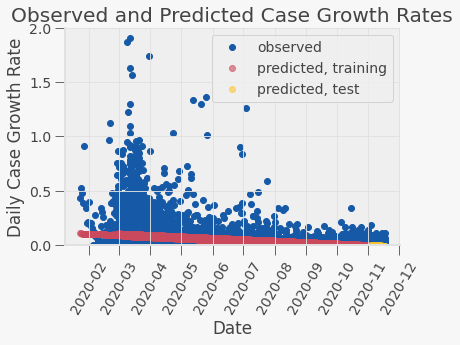

In [128]:
fig, ax = plt.subplots()
tmp = y.reset_index()
colors = qeds.themes.COLOR_CYCLE
ax.scatter(tmp["Date"],tmp["case_growth_rate"], color=colors[0], label='observed')
ax.scatter(X_train.reset_index()["Date"],mod.predict(X_train), color=colors[1],alpha=0.6, label='predicted, training')
ax.scatter(X_test.reset_index()["Date"],mod.predict(X_test), color=colors[2],alpha=0.6, label='predicted, test')
ax.set_ylim((0,2))
ax.legend()
ax.set_title("Observed and Predicted Case Growth Rates")
ax.set_ylabel("Daily Case Growth Rate")
ax.set_xlabel("Date")
ax.xaxis.set_tick_params(rotation=60)

Looking at predicted growth rates vs date, the model seems to be doing
a reasonable job. The predicted growth rates are within a reasonable
range. Notice the general increasing trend in growth rates. This will
make the longer term predictions of the model look quite dire.

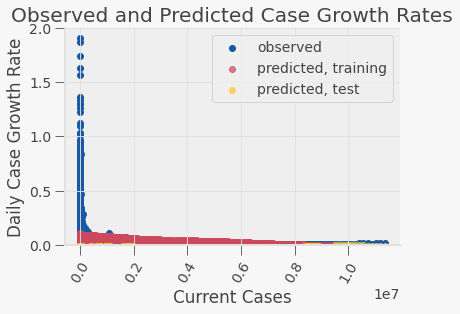

In [77]:
fig, ax = plt.subplots()
ax.scatter(X["cases"],y, color=colors[0],label='observed')
ax.scatter(X_train["cases"],mod.predict(X_train), color=colors[1],alpha=0.7,label='predicted, training')
ax.scatter(X_test["cases"],mod.predict(X_test), color=colors[2], alpha=0.7, label='predicted, test')
ax.legend()
ax.set_ylim((0,2))
ax.set_title("Observed and Predicted Case Growth Rates")
ax.set_ylabel("Daily Case Growth Rate")
ax.set_xlabel("Current Cases")
ax.xaxis.set_tick_params(rotation=60)

The fit of predictions versus current cases are not quite so good. We
see that the model often overpredicts growth rates for cases between
roughly one and ten thousand. This is likely driven by the few large
growth rates that can occur with very few cases. Our model might be
improved by letting current cases enter more flexibly.

### Predicted Case Trajectories

Our model gives a prediction of the growth rate of cases from today to
tomorrow as a function of current cases and country
characteristics. We can use the model to predict cases multiple days
into the future by repeatedly predicting growth given cases, updating
cases, and repeating.

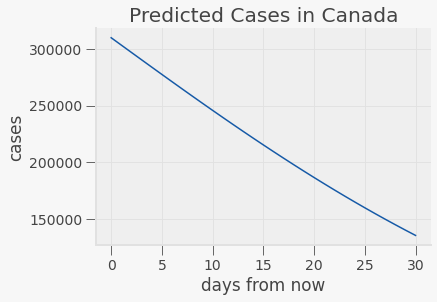

In [78]:
 def predict_path(x0, mod, days=28):
     x = x0
     y = np.zeros(days+1)
     y[0] = x["cases"]
     for d in range(days) :
         y[d+1] = (mod.predict(x)+1)*x["cases"]
         # update x
         l = 1
         while (f"cases_L{l}" in x.columns):
             if l==1 :
                 x[f"cases_L{l}"] = x["cases"]
             else :
                 x[f"cases_L{l}"] = x[f"cases_L{l-1}"]
             l = l+1
         x["cases"]=y[d+1]
         if ("daysfromstart" in x.columns):
             x["daysfromstart"]=x["daysfromstart"]+1

     fig, ax = plt.subplots()
     ax.plot(range(len(y)),y)
     ax.set_title(f"Predicted Cases in {country}")
     ax.set_xlabel('days from now')
     ax.set_ylabel('cases')
     return(y, fig, ax)

country="Canada"
yhat, fig, ax=predict_path(X.xs(country).tail(1).copy(), mod, days=30)

Note that we are taking a model trained to predict one day ahead and
using it to predict 30 days into the future. This is asking an awful
lot of the model. Also, we have seen above some obvious deficiencies
in model fit. Therefore, these predictions come with some large
caveats. Nonetheless, they do give some idea how the number of cases
might grow if Corona virus spreads in Canada in a similar way to it
has elsewhere.


<a id='exercise-0'></a>
> See exercise 1 in the [*exercise list*](#exerciselist-0)



<a id='exercise-1'></a>
> See exercise 2 in the [*exercise list*](#exerciselist-0)

## Exercises


<a id='exerciselist-0'></a>
**Exercise 1**

Examine the model's predictions for other countries.

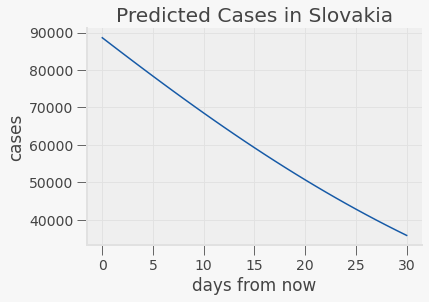

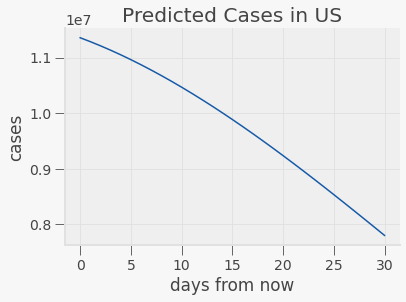

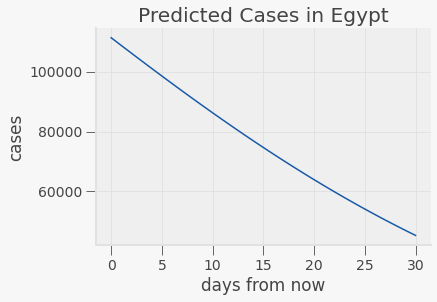

In [79]:
# your code here
def predict_path(x0, mod, days=28):
     x = x0
     y = np.zeros(days+1)
     y[0] = x["cases"]
     for d in range(days) :
         y[d+1] = (mod.predict(x)+1)*x["cases"]
         # update x
         l = 1
         while (f"cases_L{l}" in x.columns):
             if l==1 :
                 x[f"cases_L{l}"] = x["cases"]
             else :
                 x[f"cases_L{l}"] = x[f"cases_L{l-1}"]
             l = l+1
         x["cases"]=y[d+1]
         if ("daysfromstart" in x.columns):
             x["daysfromstart"]=x["daysfromstart"]+1

     fig, ax = plt.subplots()
     ax.plot(range(len(y)),y)
     ax.set_title(f"Predicted Cases in {country}")
     ax.set_xlabel('days from now')
     ax.set_ylabel('cases')
     return(y, fig, ax)

country="Slovakia"
yhat, fig, ax=predict_path(X.xs(country).tail(1).copy(), mod, days=30)

country="US"
yhat, fig, ax=predict_path(X.xs(country).tail(1).copy(), mod, days=30)

country="Egypt"
yhat, fig, ax=predict_path(X.xs(country).tail(1).copy(), mod, days=30)

([*back to text*](#exercise-0))

**Exercise 2**

Try pedicting case growth rates with other regression methods.

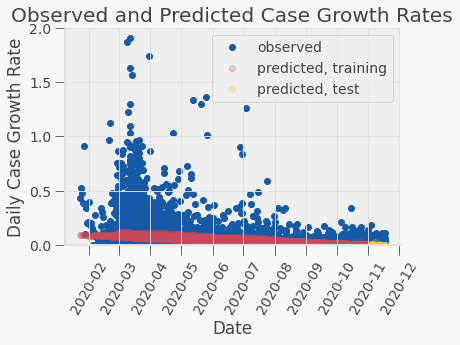

In [144]:
from sklearn import linear_model

sqft_lr_model = linear_model.LinearRegression()
lr_model = linear_model.LinearRegression()
lr_model.fit(X,y)
fig,ax = plt.subplots()

def scatter_model(mod, X, ax=None, color=colors[1], x="cases", label=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(X[x], mod.predict(X), c=color, alpha=0.25, s=1, label=label)
    return ax

X_train.reset_index()["Date"]

ax.scatter(tmp["Date"],tmp["case_growth_rate"], color=colors[0], label='observed')
ax.scatter(X_train.reset_index()["Date"], lr_model.predict(X_train), c=colors[1], alpha=0.25, label="predicted, training")
ax.scatter(X_test.reset_index()["Date"], lr_model.predict(X_test), c=colors[2], alpha=0.25, label="predicted, test")
ax.legend()
ax.set_ylim((0,2))


ax.set_title("Observed and Predicted Case Growth Rates")
ax.set_ylabel("Daily Case Growth Rate")
ax.set_xlabel("Date")
ax.xaxis.set_tick_params(rotation=60)

([*back to text*](#exercise-1))